In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'
pd.options.display.float_format = '{:,.2f}'.format

df1 = pd.read_csv('chem_by_subpara_by_ccg_monthly',dtype={'subpara': object}) # read from local csv as memory issues with pd.io

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

#q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
#subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)

## Clean the data: sort out null denominators

In [ ]:
df1_unstack = df1[['chemical','month','ratio','pct']].set_index(['chemical','month','pct'])
df1_unstack = df1_unstack.unstack()
#df1_unstack.sort_index() #.loc[df1_unstack.index.duplicated(keep=False)]
df1_unstack = df1_unstack.fillna(0)
df1_unstack
data2 = df1_unstack.stack()
#data2.head()
#####REMEMBER TO DROP WIERD CCGS!!!!!!!!!!!

### Filter out low numbers (chemical and subpara)

In [137]:
# total prescribing for each chemical
#sum numerators to find total volume for each chemical
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))
num.head()

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.reset_index().merge(num, how="inner", on="chemical",suffixes=("","_total"))
#data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))
data3 = data3.loc[(data3["num centile"]>2)]
data3 = data3[['chemical','month','ratio','pct']].set_index(['chemical','month','pct'])
data3.head()

,ratio
count,"32,270,420.00"
mean,0.14
std,0.28
min,0.00
25%,0.00
50%,0.00
75%,0.09
max,1.00


In [140]:
kurtosis_stack = data3.reset_index().groupby(['chemical','month']).apply(pd.DataFrame.kurt)
kurtosis_stack = pd.DataFrame(kurtosis_stack)
kurtosis_stack.index = kurtosis_stack.index.droplevel(2)
kurtosis_stack.columns = ['value']
kurtosis = kurtosis_stack[~kurtosis_stack.index.duplicated(keep='first')].unstack()

In [145]:
stdev_stack = data3.reset_index().groupby(['chemical','month']).std()
stdev = stdev_stack.unstack()
stdev.head()

ratio                          \
month     2010-08-01 00:00:00 UTC 2010-09-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.05                    0.06                      
0101010E0 0.00                    0.00                      
0101010F0 0.01                    0.01                      
0101010G0 0.20                    0.20                      
0101010I0 0.02                    0.07                      

                                                           \
month     2010-10-01 00:00:00 UTC 2010-11-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.05                    0.05                      
0101010E0 0.00                    0.00                      
0101010F0 0.01                    0.01                      
0101010G0 0.20                    0.21                      
0101010I0 0.07                    0.02                      

                                                           \
month     2010-12-01 00:00:00 UTC 2011-01-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.07                    0.06                      
0101010E0 0.00                    0.00                      
0101010F0 0.01                    0.01                      
0101010G0 0.21                    0.20                      
0101010I0 0.07                    0.02                      

                                                           \
month     2011-02-01 00:00:00 UTC 2011-03-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.06                    0.08                      
0101010E0 0.00                    0.00                      
0101010F0 0.01                    0.01                      
0101010G0 0.21                    0.20                      
0101010I0 0.02                    0.02                      

                                                           \
month     2011-04-01 00:00:00 UTC 2011-05-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.06                    0.06                      
0101010E0 0.00                    0.00                      
0101010F0 0.01                    0.01                      
0101010G0 0.20                    0.20                      
0101010I0 0.02                    0.04                      

                    ...                                    \
month               ...           2016-11-01 00:00:00 UTC   
chemical            ...                                     
0101010C0           ...           0.06                      
0101010E0           ...           nan                       
0101010F0           ...           0.01                      
0101010G0           ...           0.23                      
0101010I0           ...           0.06                      

                                                           \
month     2016-12-01 00:00:00 UTC 2017-01-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.07                    0.07                      
0101010E0 nan                     nan                       
0101010F0 0.02                    0.02                      
0101010G0 0.24                    0.24                      
0101010I0 0.05                    0.05                      

                                                           \
month     2017-02-01 00:00:00 UTC 2017-03-01 00:00:00 UTC   
chemical                                                    
0101010C0 0.06                    0.07                      
0101010E0 nan                     nan                       
0101010F0 0.02                    0.01                      
0101010G0 0.24                    0.24                      
0101010I0 0.05                    0.05                      

                                                           \
month     2017-04-01 00:00:00 UTC 2017-05-01 00:00:00 U

# CUSUM

In [113]:
def cusum(df, months_smoothing = 12, sensitivity = 5):
    
    # remove date labels from columns
    dates = df.columns #save date labels for later
    df.columns = range(df.shape[1])

    # create necessary tables with same index
    smax = pd.DataFrame(index=df.index)
    smin = pd.DataFrame(index=df.index)
    reference_value = pd.DataFrame(index=df.index)
    threshold = pd.DataFrame(index=df.index)
    alert = pd.DataFrame(index=df.index)
    not_alert = pd.DataFrame(index=df.index)

    # set initial values for s
    smax[0] = 0
    smin[0] = 0

    # set initial reference value for each 
    reference_value[0] = df.loc[:,0:months_smoothing-1].mean(axis=1)
    #set initial threshold
    threshold[0] = df.loc[:,0:months_smoothing-1].std(axis=1, ddof=0) * sensitivity

    # loop over months of data
    for i in range(1,df.shape[1]):

        # logic to determine alerts from previous month
        alert = (smax[i-1] > threshold[i-1]) | (smin[i-1] < -threshold[i-1])
        not_alert = (smax[i-1] <= threshold[i-1]) & (smin[i-1] >= -threshold[i-1])
        ## I'm sure there's a way of doing without this ^ one,
            # just coudn't work out the syntax to slice pandas rows
            # based on the opposite of the array of boolean values

        # reference value and threshold:
        ##append previous value if no alert
        reference_value.loc[not_alert, i] = reference_value.loc[not_alert, i-1]
        threshold[i] = threshold[i-1]

        ## reset reference after alert
        reference_value.loc[alert, i] = df.loc[alert,i-months_smoothing:i-1].mean(axis=1)

        # CUSUM calculation (adding on previous s values done elsewhere)
        ##threshold[[i]] / sensitivity is a way of deriving stdev without generating it again
        smax[i] = df[i] - (reference_value[i] + (0.5 * threshold[i] / sensitivity))
        smin[i] = df[i] - (reference_value[i] - (0.5 * threshold[i] / sensitivity))

        # retrigger logic
        retrigger_pos = (smax[i] > 0) & (smax[i-1] > threshold[i-1])
        retrigger_neg = (smin[i] < 0) & (smin[i-1] < -threshold[i-1])
        cont_cumulative = not_alert|retrigger_pos|retrigger_neg
        thres_res = alert!=retrigger_pos|retrigger_neg

        # reset threshold
        threshold.loc[thres_res, i] = df.loc[thres_res,i-months_smoothing:i-1].std(axis=1, ddof=0) * sensitivity

        # add s from previous month if no trigger, or retrigger
        smax.loc[cont_cumulative, i] = smax.loc[cont_cumulative, i] + smax.loc[cont_cumulative, i-1]
        smin.loc[cont_cumulative, i] = smin.loc[cont_cumulative, i] + smin.loc[cont_cumulative, i-1]

        # set baselines of zero
        smax.loc[smax[i] < 0, i] = 0
        smin.loc[smin[i] > 0, i] = 0

    # determine &export alerts
    alert_pos = (smax > threshold)
    #alert_pos.to_csv('alert_pos_pandas.csv')

    alert_neg = (smin < -threshold)
    #alert_neg.to_csv('alert_neg_pandas.csv')
    return {'smax':smax, 'smin':smin,'reference_value':reference_value,
           'threshold':threshold, 'alert':alert, 'alert_pos':alert_pos,
           'alert_neg':alert_neg}
# other potentially useful outputs (for drawing graphs etc)
#smax
#smin
#value
#reference_value
#threshold

In [64]:
import base64
import requests
from time import sleep
from itertools import chain
from cStringIO import StringIO
from datetime import timedelta, date
from IPython.display import display, HTML

%pylab inline

# Turn off the max column width so the HTML 
# image tags don't get truncated 
pd.set_option('display.max_colwidth', -1)

# Turning off the max column will display all the data in
# our arrays so limit the number of element to display
pd.set_option('display.max_seq_items', 2)

def sparkline(data, figsize=(4, 0.25), **kwags):
    """
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    data = list(data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])    

    plt.plot(len(data) - 1, data[len(data) - 1], 'r.')

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)
    
    img = StringIO()
    plt.savefig(img)
    img.seek(0)
    plt.close()
    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()))

Populating the interactive namespace from numpy and matplotlib


In [130]:
def get_data(df):
    change_from = reference_value.copy()
    change = pd.DataFrame(index=df.index)
    change[0] = 0.0
    change_proportion = pd.DataFrame(index=df.index)
    change_proportion[0] = 0.0
    duration = pd.DataFrame(index=df.index)
    duration[0] = 0
    cusum_out = cusum(df)
    smax = cusum_out['smax']
    smain = cusum_out['smin']
    
    for i in range(1,df.shape[1]):
        change_from[i].loc[(smax[i]!=0) | (smin[i]!=0)] = change_from[i-1]

        change[i] = (change_from[i]) - (change_from[i-1])
        change_proportion[i] = (change_from[i] - change_from[i-1]) /change_from[i-1]

        duration[i] = 1
        duration[i].loc[(smax[i-1]>0.0001) | (smin[i-1]<-0.0001)] = duration[i-1] +1
    change.columns = dates
    
    change_proportion.columns = dates
    duration.columns = dates

    output = change.stack().reset_index()
    output = output.merge(change_proportion.stack().reset_index(),
                          how='left',
                          on=['chemical','month'])
    output = output.merge(duration.stack().reset_index(),
                          how='left',
                          on=['chemical','month'])
    output.columns = ['code','month','absolute_change','proportion_change','duration']
    output = output.merge(chem,
                          how='left',
                          left_on='code',
                          right_on='chemical_code')

    output = output.set_index(['code'])

    pd.options.display.float_format = '{:,.2f}'.format
    return output

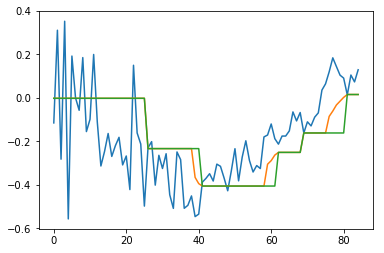

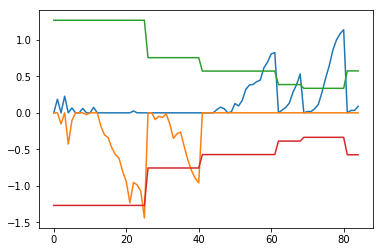

In [129]:
import matplotlib.pyplot as plt
measure = '0501050B0'
plt.plot(df.loc[measure])
plt.plot(reference_value.loc[measure])
plt.plot(change_from.loc[measure])

plt.show()

plt.plot(smax.loc[measure])
plt.plot(smin.loc[measure])
plt.plot(threshold.loc[measure])
plt.plot(-threshold.loc[measure])
plt.show()

In [122]:
def make_table(df, sort='proportion_change'):
    output = get_data(df)
    output2 = output.sort_values(by=sort,
                               ascending=False).head(20)
    spl = output2.merge(kurtosis_stack.reset_index(),
                        how='left',
                        left_index=True,
                        right_on='chemical')
    spl = spl.groupby(['chemical']).aggregate({'value': sparkline})
    output2 = output2.merge(spl,
                          how='left',
                          left_index=True,
                          right_index=True)

    return HTML(output2.to_html(escape=False))

# Results

## Change in kurtosis

In [148]:
make_table(kurtosis,sort='absolute_change')

,month,absolute_change,proportion_change,duration,chemical,chemical_code,value
code,,,,,,,
1310011AA,2014-04-01 00:00:00 UTC,157.78,2.62,23,Retapamulin,1310011AA,
1001022G0,2017-07-01 00:00:00 UTC,119.09,4.02,15,Hydrocortisone Acetate,1001022G0,
0301012S0,2013-02-01 00:00:00 UTC,105.03,15.63,22,Orciprenaline Sulfate,0301012S0,
0202010V0,2012-10-01 00:00:00 UTC,100.45,3.64,13,Metolazone,0202010V0,
1202010L0,2015-11-01 00:00:00 UTC,98.65,2.18,15,Flunisolide,1202010L0,
0102000L0,2015-08-01 00:00:00 UTC,92.93,9.74,48,Glycopyrronium Bromide,0102000L0,
1203010T0,2014-03-01 00:00:00 UTC,88.80,1.05,12,Triamcinolone Acetonide,1203010T0,
0407020H0,2012-03-01 00:00:00 UTC,88.60,1.49,13,Dipipanone Hydrochloride,0407020H0,
0606020C0,2015-11-01 00:00:00 UTC,83.62,6.19,15,Etidronate Disodium,0606020C0,


In [131]:
make_table(kurtosis,sort='proportion_change')

,month,absolute_change,proportion_change,duration,chemical,chemical_code,value
code,,,,,,,
0501050B0,2012-10-01 00:00:00 UTC,-0.23,127.67,14,Clarithromycin,0501050B0,
1310011M0,2015-05-01 00:00:00 UTC,-0.31,66.64,11,Mupirocin,1310011M0,
1311010I0,2015-09-01 00:00:00 UTC,24.13,40.64,58,Isopropyl Alcohol,1311010I0,
0703010G0,2016-01-01 00:00:00 UTC,7.43,36.71,4,Combined Ethinylestradiol 35mcg,0703010G0,
0905012I0,2015-02-01 00:00:00 UTC,0.51,19.25,20,Cinacalcet Hydrochloride,0905012I0,
0202080K0,2016-11-01 00:00:00 UTC,26.10,16.87,26,Furosemide/Potassium,0202080K0,
1305020A0,2012-07-01 00:00:00 UTC,82.87,15.91,19,Acitretin,1305020A0,
0301012S0,2013-02-01 00:00:00 UTC,105.03,15.63,22,Orciprenaline Sulfate,0301012S0,
0403030P0,2015-08-01 00:00:00 UTC,17.24,15.63,7,Paroxetine Hydrochloride,0403030P0,


## Standard deviation

In [147]:
make_table(stdev,sort='absolute_change')

,month,absolute_change,proportion_change,duration,chemical,chemical_code,value
code,,,,,,,
1310011AA,2014-08-01 00:00:00 UTC,157.78,2.62,20,Retapamulin,1310011AA,
0401010B0,2014-07-01 00:00:00 UTC,131.13,1.87,12,Chloral Hydrate,0401010B0,
0401010F0,2012-04-01 00:00:00 UTC,119.81,6.99,12,Clomethiazole,0401010F0,
1003020V0,2014-09-01 00:00:00 UTC,112.68,1.86,7,Turpentine Oil,1003020V0,
1203040G0,2017-03-01 00:00:00 UTC,105.49,3.84,11,Hexetidine,1203040G0,
0102000L0,2015-08-01 00:00:00 UTC,92.93,9.74,48,Glycopyrronium Bromide,0102000L0,
1106000AK,2014-05-01 00:00:00 UTC,78.57,4.15,12,Tafluprost,1106000AK,
0408010AG,2013-04-01 00:00:00 UTC,74.30,4.35,23,Stiripentol,0408010AG,
0203020X0,2012-06-01 00:00:00 UTC,72.27,3.53,17,Dronedarone Hydrochloride,0203020X0,


In [146]:
make_table(stdev,sort='proportion_change')

,month,absolute_change,proportion_change,duration,chemical,chemical_code,value
code,,,,,,,
0906050P0,2016-11-01 00:00:00 UTC,0.07,"1,577.91",1,Vitamin E,0906050P0,
0501050B0,2014-07-01 00:00:00 UTC,-0.40,222.69,44,Clarithromycin,0501050B0,
0202080B0,2012-07-01 00:00:00 UTC,0.43,111.76,1,Bendroflumethiazide/Potassium,0202080B0,
1310011M0,2015-05-01 00:00:00 UTC,-0.31,66.64,11,Mupirocin,1310011M0,
0410000P0,2011-12-01 00:00:00 UTC,19.93,55.44,1,NaN,NaN,
0703010G0,2016-01-01 00:00:00 UTC,7.43,36.71,4,Combined Ethinylestradiol 35mcg,0703010G0,
1311010I0,2012-08-01 00:00:00 UTC,0.46,15.94,1,Isopropyl Alcohol,1311010I0,
0403030P0,2015-08-01 00:00:00 UTC,17.24,15.63,6,Paroxetine Hydrochloride,0403030P0,
0501040U0,2015-03-01 00:00:00 UTC,0.47,15.62,4,Tobramycin,0501040U0,
